In [252]:
#Libraries
import pandas as pd
import numpy as np
import random
from scipy.sparse import csr_matrix
from scipy.linalg import svd
import matplotlib.pyplot as plt


## Load and inspect data

In [253]:
# Define your column headers
column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
df_activity = pd.read_csv('activity_train.csv', names=column_headers)

column_headers = ['Uniprot_IDs', 'ChEMBL_IDs', 'Activity']  
# Read the CSV file with custom headers
df_activity_validation = pd.read_csv('activity_test_blanked.csv', names=column_headers)

mol_bits = pd.read_pickle('mol_bits.pkl')

In [254]:
df_activity

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL207881,4
1,O14842,CHEMBL2022244,6
2,O14842,CHEMBL2022245,2
3,O14842,CHEMBL2022246,1
4,O14842,CHEMBL2022247,4
...,...,...,...
135706,Q9Y5Y4,CHEMBL4214909,6
135707,Q9Y5Y4,CHEMBL4218012,2
135708,Q9Y5Y4,CHEMBL4217503,7
135709,Q9Y5Y4,CHEMBL4204359,8


In [255]:
# check if how many molecules activate on the same protein
df_activity.groupby('Uniprot_IDs')['ChEMBL_IDs'].nunique().sort_values(ascending=False)

Uniprot_IDs
P14416    8045
P29274    5578
P35462    5106
P30542    4812
P08908    4741
          ... 
Q8TDV5      48
P43220      48
Q96RJ0      44
P30550      44
P47211      40
Name: ChEMBL_IDs, Length: 144, dtype: int64

In [256]:
df_activity_validation

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [257]:
# check how many molecules in the test set are not in the training set
df_activity_validation[~df_activity_validation['ChEMBL_IDs'].isin(df_activity['ChEMBL_IDs'])]

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [258]:
# check how many proteins in the test set are not in the training set
df_activity_validation[~df_activity_validation['Uniprot_IDs'].isin(df_activity['Uniprot_IDs'])]

,Uniprot_IDs,ChEMBL_IDs,Activity


In [259]:
# print how many unique proteins and molecules are in the training set
print('Number of unique proteins in the training set:', df_activity['Uniprot_IDs'].nunique())
print('Number of unique molecules in the training set:', df_activity['ChEMBL_IDs'].nunique())

Number of unique proteins in the training set: 144
Number of unique molecules in the training set: 72631


In [260]:
# Get molecule information/non-latent features
mol_bits = pd.read_pickle('mol_bits.pkl')

#Create a sparse matrix with the mol_bits dataset and generate a subset for initial analysis

def create_sparse_matrix(data, num_rows):
    random.seed(42)  # Set a seed for reproducibility
    sampled_indices = random.sample(range(len(data)), num_rows)
    ChEMBL_IDs = [list(data.keys())[i] for i in sampled_indices]
    structural_features = [list(data.values())[i] for i in sampled_indices]

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(num_rows, num_features))
    
    return sparse_matrix, ChEMBL_IDs

sparse_matrix, ChEMBL_IDs = create_sparse_matrix(mol_bits, len(mol_bits))
dense_matrix = sparse_matrix.toarray()

df_mol_bits = pd.DataFrame(dense_matrix, index=ChEMBL_IDs)
df_mol_bits

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
CHEMBL4586090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CHEMBL292574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL3977929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL473197,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL243694,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL146720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL2113198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL552506,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL301416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [261]:
# check if all molecules in df_activity have a fingerprint
df_activity[~df_activity['ChEMBL_IDs'].isin(df_mol_bits.index)]

,Uniprot_IDs,ChEMBL_IDs,Activity


In [262]:
# 1. Step: Create user X items (molecules X proteins) matrix

# Define function
def create_interaction_matrix(df, molecule_col, protein_col, activity_col):
    interactions = df.pivot_table(index=molecule_col, columns=protein_col, values=activity_col, aggfunc='mean')
    interactions = interactions.fillna(0)
    return interactions

# Create the interaction matrix
interactions = create_interaction_matrix(df_activity, 'ChEMBL_IDs', 'Uniprot_IDs', 'Activity')

# Create the interaction matrix
interactions

Uniprot_IDs,O14842,O43193,O43613,O43614,O95665,P05067,P07550,P08172,P08173,P08588,...,Q9GZQ6,Q9H244,Q9H3N8,Q9HC97,Q9NQS5,Q9UBY5,Q9UKP6,Q9Y5N1,Q9Y5X5,Q9Y5Y4
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
# Use a mask to hide the test set from the training set when training the model
def train_test_split_rectangle(interactions, test_ratio_items=0.2, test_ratio_users=0.2):
    # Determine the size of the test set for items and users separately
    num_molecules, num_proteins = interactions.shape
    num_test_items = int(test_ratio_items * num_proteins)
    num_test_users = int(test_ratio_users * num_molecules)
    print(f"Removing {num_test_items} items and {num_test_users} users from the bottom-right corner of the matrix for testing.")
    
    # Create train and test masks
    train_mask = np.ones(interactions.shape)
    test_mask = np.zeros(interactions.shape)
    
    # Indices for the test set (bottom-right corner)
    test_proteins_indices = range(num_proteins - num_test_items, num_proteins)
    test_molecules_indices = range(num_molecules - num_test_users, num_molecules)
    
    # Set the mask values
    for i in test_molecules_indices:
        for j in test_proteins_indices:
            train_mask[i, j] = 0
            test_mask[i, j] = 1
    
    # Apply the masks
    interaction_matrix = interactions.to_numpy()
    train_matrix = interaction_matrix * train_mask
    test_matrix = interaction_matrix * test_mask
    
    return train_matrix, test_matrix, train_mask, test_mask, interactions.index, interactions.columns

# Perform the train-test split
train_matrix, test_matrix, train_mask, test_mask, user_index, item_columns = train_test_split_rectangle(interactions, test_ratio_items=0.4, test_ratio_users=0.4)

# Convert matrices back to DataFrames for easier handling
train_df = pd.DataFrame(train_matrix, index=user_index, columns=item_columns)
test_df = pd.DataFrame(test_matrix, index=user_index, columns=item_columns)

# Print the shapes to verify
print(f"Train matrix shape: {train_df.shape}")
print(f"Test matrix shape: {test_df.shape}")

train_df

Removing 57 items and 29052 users from the bottom-right corner of the matrix for testing.
Train matrix shape: (72631, 144)
Test matrix shape: (72631, 144)


Uniprot_IDs,O14842,O43193,O43613,O43614,O95665,P05067,P07550,P08172,P08173,P08588,...,Q9GZQ6,Q9H244,Q9H3N8,Q9HC97,Q9NQS5,Q9UBY5,Q9UKP6,Q9Y5N1,Q9Y5X5,Q9Y5Y4
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL100045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL99987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [264]:
# just quickly check the masks -> working
print("Train Mask:")
display(train_mask)
print("Test Mask:")
display(test_mask)

Train Mask:


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Test Mask:


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [265]:
# 2. Step: Apply SVD
U, sigma, Vt = svd(train_matrix, full_matrices=False)
U.shape

(72631, 144)

In [266]:
Vt.shape

(144, 144)

In [267]:
def make_init_PQ(U, S, Vt, k):
    # Extract the first k columns of U and Vt
    Uk = U[:, :k]  # Users x latent factors
    Sk = np.diag(S[:k])  # Create a diagonal matrix for the top k singular values
    Vk = Vt[:k, :]  # Latent factors x items
    
    # Compute P and Q matrices
    P = np.dot(Uk, Sk)  # P = U * Sigma
    Q = Vk  # Q = V.T
    return P, Q

k = 2
P, Q = make_init_PQ(U, sigma, Vt, k)

# Print the shapes of P and Q to verify
print(f"P shape: {P.shape}")
print(f"Q shape: {Q.shape}")

P shape: (72631, 2)
Q shape: (2, 144)


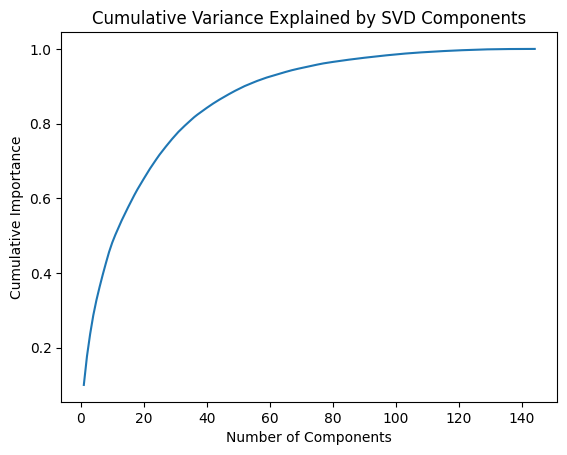

In [268]:
# Calculate cumulative variance explained from sigma for each k

variance_explained = sigma**2
total_variance = np.sum(variance_explained)

# Calculate cumulative importance
cumulative_importance = np.cumsum(variance_explained) / total_variance

# Create a DataFrame to display the results
df = pd.DataFrame({
    'k': np.arange(1, len(cumulative_importance) + 1),
    'Cumulative Importance': cumulative_importance
})

# plot the cumulative importance
plt.plot(df['k'], df['Cumulative Importance'])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Variance Explained by SVD Components')
plt.show()


In [269]:
# Function to create a mask for the observed ratings
def create_mask(matrix):
    return 1 * (matrix > 0)

# Function to calculate error using the precomputed mask and its sum
def calc_rmse(R, P, Q, mask, mask_sum):
    error = (R - np.dot(P, Q)) * mask
    return np.sqrt(np.sum(error**2) / mask_sum)

# Example usage with train and test matrices
train_mask = create_mask(train_matrix)
test_mask = create_mask(test_matrix)

train_mask_sum = np.sum(train_mask)
test_mask_sum = np.sum(test_mask)

# Calculate training error
train_error = calc_rmse(train_matrix, P, Q, train_mask, train_mask_sum)
print(f"Training RMSE: {train_error}")

# Calculate test error
test_error = calc_rmse(test_matrix, P, Q, test_mask, test_mask_sum)
print(f"Test RMSE: {test_error}")

Training RMSE: 4.850142648480752
Test RMSE: 5.861507605672985


In [270]:
# Regularized stochastic gradient descent
def run_epoch_reg(elems, R, P, Q, learning_rate, reg_p=1, reg_q=1):
    random.shuffle(elems)
    for u, i in elems:
        r_ui = R[u, i]
        delta = 2 * (r_ui - P[u, :] @ Q[:, i])
        P[u, :] += learning_rate * (delta * Q[:, i] - reg_p * P[u, :])
        Q[:, i] += learning_rate * (delta * P[u, :] - reg_q * Q[:, i])
    return P, Q

# Recommender SGD function
def recommender_sgd_reg(train_matrix, test_matrix, num_epochs=100, k=2, learning_rate=0.01, reg_p=1, reg_q=1, output_rmses=False):
    # Initialization
    train_rmses = []
    test_rmses = []
    U, S, V = svd(train_matrix, full_matrices=False)
    P, Q = make_init_PQ(U ,S, V, k)
    rated_elements = [(u, i) for u, i in np.argwhere(train_matrix > 0)]

    # Create masks
    train_mask = create_mask(train_matrix)
    test_mask = create_mask(test_matrix)

    train_mask_sum = np.sum(train_mask)
    test_mask_sum = np.sum(test_mask)

    # Run all the epochs
    for epoch in range(num_epochs):
        P, Q = run_epoch_reg(rated_elements, train_matrix, P, Q, learning_rate, reg_p, reg_q)
        train_rmse = calc_rmse(train_matrix, P, Q, train_mask, train_mask_sum)
        test_rmse = calc_rmse(test_matrix, P, Q, test_mask, test_mask_sum)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    if output_rmses == False:
        return P, Q
    else:
        return P, Q, train_rmses, test_rmses

k = 10
learning_rate = 0.001
num_epochs = 100
reg_p = 1
reg_q = 1

P,Q, train_rmses, test_rmses = recommender_sgd_reg(train_matrix, test_matrix, num_epochs=num_epochs, k=k, learning_rate=learning_rate, reg_p=reg_p, reg_q=reg_q, output_rmses=True)

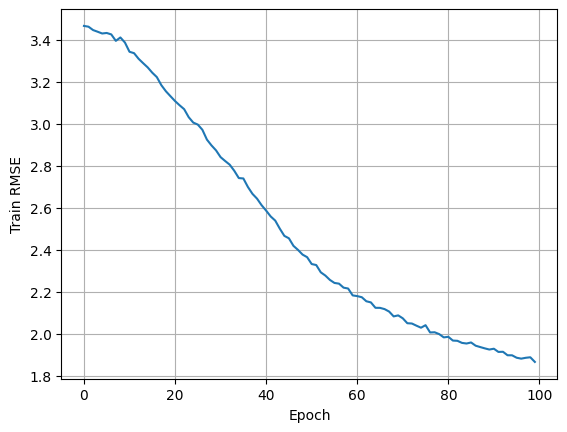

In [271]:
# Plot train RMSEs
plt.plot(train_rmses)
plt.xlabel('Epoch')
plt.ylabel('Train RMSE')
plt.grid()
plt.show()

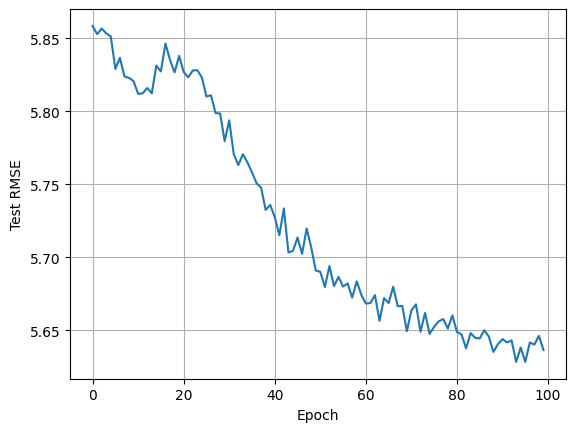

In [272]:
# Plot test RMSEs
plt.plot(test_rmses)
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.grid()
plt.show()

In [180]:
# Read csv, write results and write to csv
df_results = pd.read_csv('results.csv')

# Add the results to the DataFrame
# Create a DataFrame for the new data
new_data = pd.DataFrame([{
    'k_latent_factors': k,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    'reg_p': reg_p,
    'reg_q': reg_q,
    'train_rmses': train_rmses,
    'test_rmses': test_rmses,
}])

# Concatenate the new data with the existing DataFrame
df_results = pd.concat([df_results, new_data], ignore_index=True)

# Remove duplicates
df_results = df_results.drop_duplicates(subset=['k_latent_factors', 'learning_rate', 'num_epochs', 'reg_p', 'reg_q'], keep='last')

df_results.to_csv('results.csv', index=False)
df_results

,k_latent_factors,learning_rate,reg_p,reg_q,train_rmses,test_rmses,num_epochs
1,10,0.001,1,1,"[3.5597096312433987, 3.5439419525305635, 3.527...","[4.427659609329391, 4.426449371106876, 4.41583...",200.0


## Implement user features as bias and interaction

In [185]:
# prepare molecule fingerprints
desired_order = interactions.index
df_mol_bits_reindexed = df_mol_bits.reindex(desired_order)
df_mol_bits_reindexed

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
ChEMBL_IDs,,,,,,,,,,,,,,,,,,,,,
CHEMBL10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1000,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL100045,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL99982,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL99983,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
CHEMBL99987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
molecule_features = df_mol_bits_reindexed.to_numpy()
print(molecule_features.shape)
molecule_features


(72631, 2048)

In [216]:
# New error function to incorporate all information
def calc_rmse_complete(R, P, Q, T, D, item_biases, user_biases, global_bias, user_features, mask, mask_sum):
    # Compute the user feature interactions
    t_u = user_features @ T  # Shape (num_users, k)
    d_u = user_features @ D  # Shape (num_users,)
    
    # Compute the predicted ratings
    R_pred = global_bias + item_biases + user_biases[:, np.newaxis] + d_u[:, np.newaxis] + (P + t_u) @ Q
    
    # Calculate the error
    error = (R - R_pred) * mask
    
    # Return RMSE
    return np.sqrt(np.sum(error**2) / mask_sum)

In [209]:
# Regularized stochastic gradient descent with biases and user features
def run_epoch_reg_complete(elems, R, P, Q, T, D, item_biases, user_biases, global_bias, user_features, learning_rate, reg_p=1, reg_q=1, reg_t=1, reg_d=1, reg_b=1):
    random.shuffle(elems)
    for u, i in elems:
        # Get all matrices and vectors
        r_ui = R[u, i] # Actual prediction
        x_u = user_features[u, :] # Feature vector for user u
        q_i = Q[:, i] # Latent factors for item i
        p_u = P[u, :] # Latent factors for user u
        b_i = item_biases[i] # Bias for item i
        b_u = user_biases[u] # Bias for user u
        t_u = x_u @ T # User_features interaction term
        d_u = x_u @ D # User features bias term

        # get the prediction
        r_ui_pred = np.dot(q_i, p_u + t_u) + b_i + b_u + global_bias + d_u

        # Get delta
        delta = 2 * (r_ui - r_ui_pred)

        # Update parameters
        global_bias += learning_rate * delta
        b_i += learning_rate * (delta - reg_b * b_i)
        b_u += learning_rate * (delta - reg_b * b_u)
        P[u, :] += learning_rate * (delta * q_i - reg_p * p_u)
        Q[:, i] += learning_rate * (delta * (p_u + t_u) - reg_q * q_i)
        T += learning_rate * (delta * np.outer(x_u, q_i) - reg_t * T)
        D += learning_rate * (delta * x_u - reg_d * D)

    return P, Q, T, D, item_biases, user_biases, global_bias


In [225]:
# test adding the molecule features to !
# Initialize P and Q with SVD
U, S, V = svd(train_matrix, full_matrices=False)
P, Q = make_init_PQ(U, S, V, k)

# Recommender SGD function
def recommender_sgd_reg_complete(train_matrix, test_matrix, user_features, num_epochs=100, k=2, learning_rate=0.01, reg_p=1, reg_q=1, reg_t=1, reg_d=1, reg_b=1, output_rmses=False):
    # Initialization
    train_rmses = []
    test_rmses = []
    U, S, V = svd(train_matrix, full_matrices=False)
    P, Q = make_init_PQ(U ,S, V, k)
    T = np.random.normal(scale=1./k, size=(user_features.shape[1], k))
    D = np.random.normal(scale=1./k, size=(user_features.shape[1],))
    item_biases = np.random.normal(scale=0.01, size=len(interactions.columns))
    user_biases = np.random.normal(scale=0.01, size=len(interactions.index))
    global_bias = np.mean(train_matrix[np.where(train_matrix != 0)])

    rated_elements = [(u, i) for u, i in np.argwhere(train_matrix > 0)]

    # Create masks
    train_mask = create_mask(train_matrix)
    test_mask = create_mask(test_matrix)

    train_mask_sum = np.sum(train_mask)
    test_mask_sum = np.sum(test_mask)

    # Run all the epochs
    for epoch in range(num_epochs):
        P, Q, T, D, item_biases, user_biases, global_bias = run_epoch_reg_complete(rated_elements, train_matrix, P, Q, T, D, item_biases, user_biases, global_bias, user_features, learning_rate, reg_p, reg_q, reg_t, reg_d, reg_b)
        train_rmse = calc_rmse_complete(train_matrix, P, Q, T, D, item_biases, user_biases, global_bias, user_features, train_mask, train_mask_sum)
        test_rmse = calc_rmse_complete(test_matrix, P, Q, T, D, item_biases, user_biases, global_bias, user_features, test_mask, test_mask_sum)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

    if output_rmses == False:
        return P, Q, T, D, item_biases, user_biases, global_bias
    else:
        return P, Q, T, D, item_biases, user_biases, global_bias, train_rmses, test_rmses

k = 2
learning_rate = 0.001
num_epochs = 100
reg_p = 1
reg_q = 1
reg_t = 1
reg_d = 1
reg_b = 1

P, Q, T, D, item_biases, user_biases, global_bias, train_rmses, test_rmses = recommender_sgd_reg_complete(train_matrix, test_matrix, molecule_features, num_epochs=num_epochs, k=k, learning_rate=learning_rate, reg_p=reg_p, reg_q=reg_q, reg_t=reg_t, reg_d=reg_d, reg_b=reg_b, output_rmses=True)

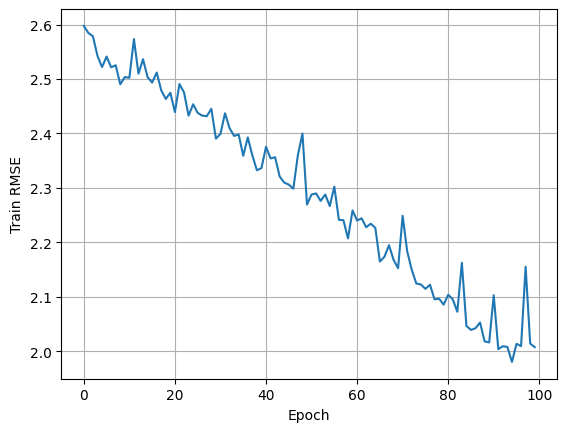

In [226]:
# Plot train RMSEs
plt.plot(train_rmses)
plt.xlabel('Epoch')
plt.ylabel('Train RMSE')
plt.grid()
plt.show()

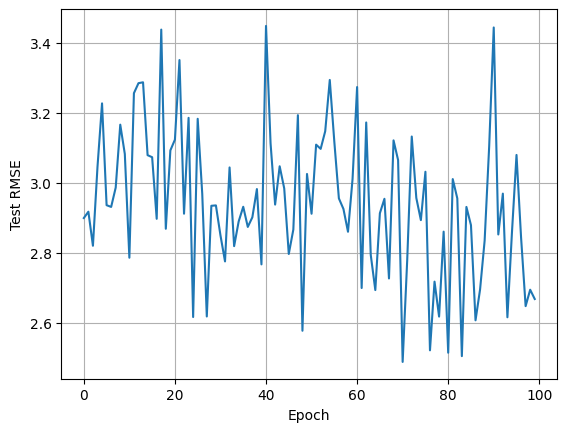

In [227]:
# Plot test RMSEs
plt.plot(test_rmses)
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.grid()
plt.show()

In [ ]:
# @TODO: Hyperparameter tuning -> see TP10 for inspiration

In [ ]:
# @TODO: Do a final run with the best hyperparameters on the full dataset and use these results for the final prediction

## Predicting on the blanked dataset

In [224]:
# prediction set is already loaded as df_activity_validation
df_activity_validation

,Uniprot_IDs,ChEMBL_IDs,Activity
0,O14842,CHEMBL2022258,0
1,O14842,CHEMBL2047161,0
2,O14842,CHEMBL2047163,0
3,O14842,CHEMBL2047168,0
4,O14842,CHEMBL2047169,0
...,...,...,...
4623,Q9Y5Y4,CHEMBL4208314,0
4624,Q9Y5Y4,CHEMBL4205421,0
4625,Q9Y5Y4,CHEMBL4207935,0
4626,Q9Y5Y4,CHEMBL4208884,0


In [ ]:
# 